In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file = pd.read_csv('/content/geolyrics (1).csv')

In [ ]:
file.head()

,artist_id,artist,track_name,release_date,popularity,track_id,album_id,external_id,explicit,is_local,tiktok_video_count,lyrics,location_mention,names_of_location,count
0,46pWGuE3dSwY3bMMXGBvVS,Rema,Charm,2023-04-27,75,1iBWjQ9af9NnUd5xnQDB3k,0nayxjaX54Frd7GsZq6Pbs,Rave & Roses Ultra,True,False,299000,"""Charm""\n\nLondon\nAnother banger\n\nCome here...",no,NaN,0
1,3wcj11K77LjEY1PkEazffa,Burna Boy,City Boys,2023-08-24,81,4RoKNqyZ9622tcAeNPNv5k,1JzjwUKkPsdHg1SQ7qa5hc,I Told Them...,True,False,590000,"""City Boys""\n\n[J Hus:]\nAyo, I'm not even gon...",yes,"london, colorado, port harcourt",3
2,3Uv5hfyuC7TkLsQ6p4ikSb,Crayon,Ngozi,2023-07-21,76,5mhM7bfzv52bzfCzlq8vH1,60dzSRKqWPNVTunBR1aHal,Trench to Triumph,False,False,412000,"""Ngozi""\n\nYou gimme light, bi ti solar\nCan f...",yes,paris,1
3,3SozjO3Lat463tQICI9LcE,Tyla,Water,2023-07-28,95,5aIVCx5tnk0ntmdiinnYvw,22sXXkKgjEuawIFL1e1tRw,Water,False,False,384000,"""Water""\n\nMake me sweat\nMake me hotter\nMake...",no,NaN,0
4,7KiINhQdLAupkwvJ0EelGG,KCee,Ojapiano,2023-06-03,69,6WZVnqQ9OZRSGZmXyHHlV3,1j2D58Awo2MGDL1nAwdF3e,Ojapiano,False,False,2060000,"[Intro]\nKcee-e, Limpopo-o-o\nJaysynth (Bring ...",yes,"limpopo, zongo",2


In [ ]:
#filter dataset for foucus duration

file['release_date'] = pd.to_datetime(file['release_date'])
condition = (file['release_date'].dt.year < 2023) & file['names_of_location'].isna()
file.drop(file[condition].index, inplace=True)
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 164
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   artist_id           100 non-null    object        
 1   artist              100 non-null    object        
 2   track_name          100 non-null    object        
 3   release_date        100 non-null    datetime64[ns]
 4   popularity          100 non-null    int64         
 5   track_id            100 non-null    object        
 6   album_id            100 non-null    object        
 7   external_id         100 non-null    object        
 8   explicit            100 non-null    bool          
 9   is_local            100 non-null    bool          
 10  tiktok_video_count  100 non-null    int64         
 11  lyrics              100 non-null    object        
 12  location_mention    100 non-null    object        
 13  names_of_location   70 non-null     object        

In [ ]:
#confirming balanced dataset 70% location mention and 30% no location

file.isna().sum()

artist_id              0
artist                 0
track_name             0
release_date           0
popularity             0
track_id               0
album_id               0
external_id            0
explicit               0
is_local               0
tiktok_video_count     0
lyrics                 0
location_mention       0
names_of_location     30
count                 14
dtype: int64

#Visualizing distribution and outliers

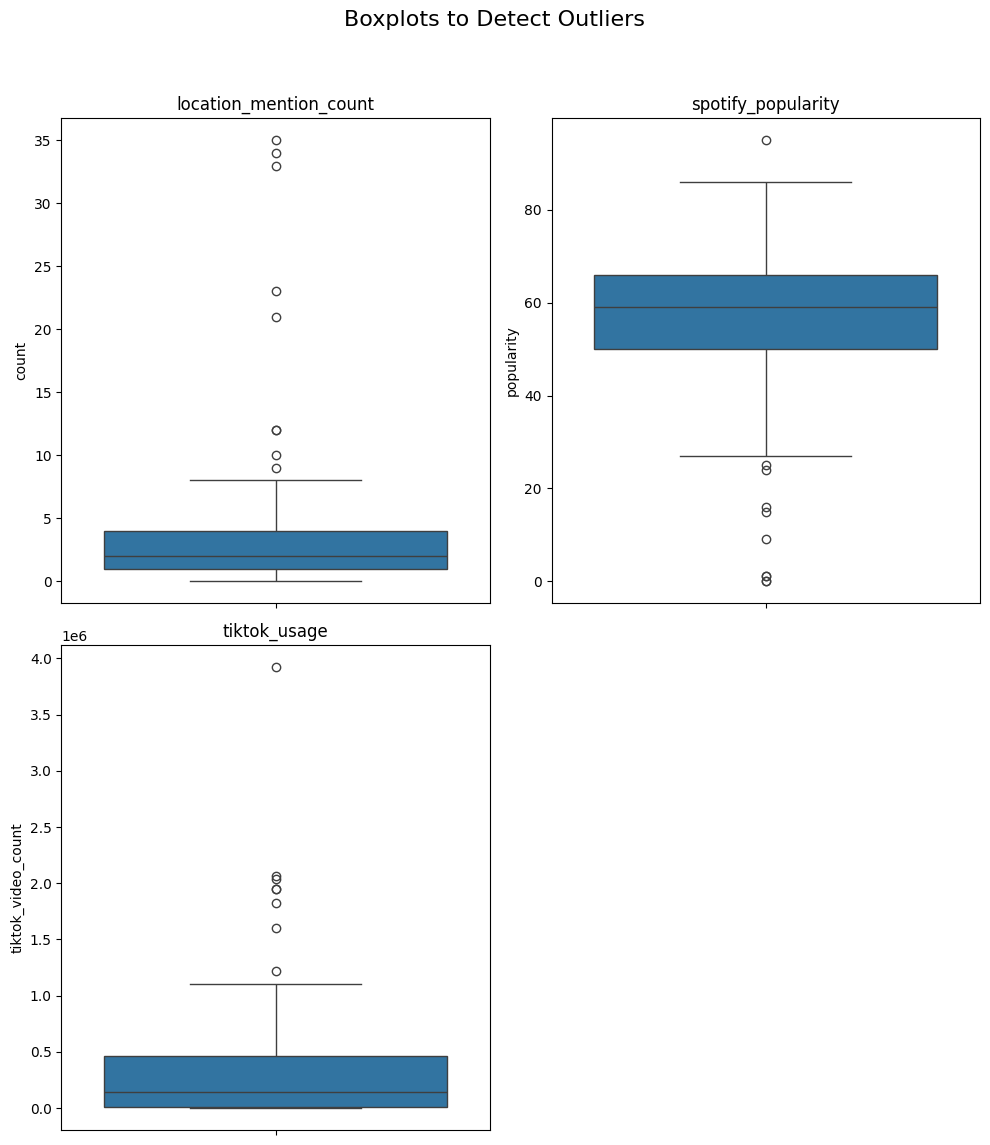

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Boxplots to Detect Outliers', fontsize=16)

sns.boxplot(ax=axes[0, 0], y=file['count']).set_title('location_mention_count', fontsize=12)
sns.boxplot(ax=axes[0, 1], y=file['popularity']).set_title('spotify_popularity', fontsize=12)
sns.boxplot(ax=axes[1, 0], y=file['tiktok_video_count']).set_title('tiktok_usage', fontsize=12)
axes[1, 1].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

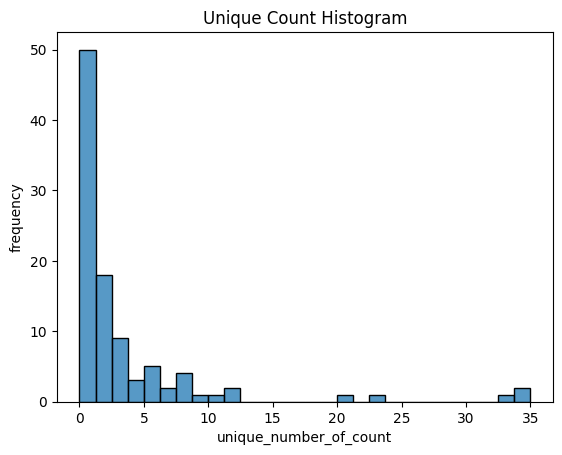

In [ ]:
file['count'] = file['count'].fillna(0).astype(int)
file['count'].value_counts(normalize=True)

sns.histplot(data=file['count'], common_norm=False, stat="count")
plt.title('Unique Count Histogram', fontsize=12)
plt.xlabel('unique_number_of_count')
plt.ylabel('frequency')
plt.show()

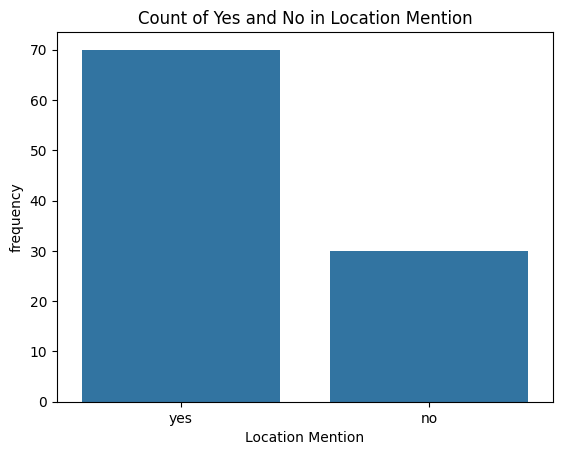

In [ ]:
count_values = file['location_mention'].value_counts()

sns.barplot(x=count_values.index, y=count_values.values)
plt.xlabel('Location Mention')
plt.ylabel('frequency')
plt.title('Count of Yes and No in Location Mention', fontsize=12)
plt.show()

In [ ]:
file_df = file.copy()

#normalize feature column and define indicator
columns_to_normalize = ['popularity', 'tiktok_video_count', 'count']
min_max_scaler = MinMaxScaler()

file_df[columns_to_normalize] = min_max_scaler.fit_transform(file_df[columns_to_normalize])

In [ ]:
#assign weight to target value and normalize
weight_popularity = 0.7
weight_tiktok = 0.3

file_df['weighted_average'] = (weight_popularity * file_df['popularity']) + (weight_tiktok * file_df['tiktok_video_count'])

In [ ]:
#encode data and define target class
bins = [0.0, 0.54999, 0.88]
labels = [0, 1]

file_df['location_mention'] = file_df['location_mention'].map({'yes': 1, 'no': 0})
file_df['explicit'] = file_df['explicit'].astype(int)

file_df['class'] = pd.cut(file_df['weighted_average'], bins=bins, labels=labels, include_lowest=True)
file_df['class'] = file_df['class'].astype(int)

In [ ]:
df = file_df[['artist', 'track_name', 'popularity', 'explicit', 'tiktok_video_count', 'location_mention', 'count', 'weighted_average', 'class']]
df.sample(7)

,artist,track_name,popularity,explicit,tiktok_video_count,location_mention,count,weighted_average,class
103,Ayra Starr,Bloody Samaritan,0.694737,1,0.110967,1,0.028571,0.519606,0
127,Fireboy DML,Bandana,0.768421,1,0.117600,1,0.114286,0.573175,1
162,Majeeed,Waka Jeje (feat. Bnxn),0.484211,0,0.000167,0,0.000000,0.338997,0
22,SPINALL,Loju (feat. Wizkid),0.589474,0,0.001410,0,0.000000,0.413055,0
73,Rema,Time N Affection,0.600000,1,0.002982,1,0.057143,0.420895,0
116,Boj,Owo Ni Koko,0.000000,1,0.000032,1,0.057143,0.000009,0
10,Asake,Amapiano,0.694737,1,0.077294,1,0.085714,0.509504,0


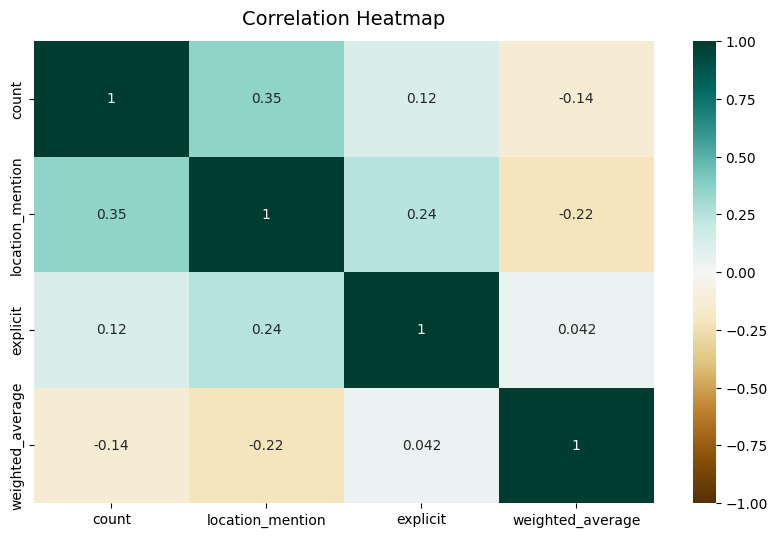

In [ ]:
#visualize corellation between metrics

df = df[['count', 'location_mention', 'explicit', 'weighted_average']]

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [ ]:
input_columns = ['location_mention', 'explicit', 'count']
output_column = 'weighted_average'

pearson_correlation_coefficients = df[input_columns + [output_column]].corr().loc[input_columns, output_column]
print("Pearson Correlation Coefficient:")
print(pearson_correlation_coefficients)

Pearson Correlation Coefficient:
location_mention   -0.215029
explicit            0.042363
count              -0.138480
Name: weighted_average, dtype: float64


#Training

In [ ]:
# Split the data into training and testing sets
X = df[['location_mention', 'explicit', 'count']]
y = df['weighted_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##SVM

In [ ]:
# Initialize and train the SVM model
from sklearn.svm import SVR

svm_model = SVR()
svm_model.fit(X_train, y_train)

SVR()

In [ ]:
# Make predictions on the testing set
predictions = svm_model.predict(X_test)
predictions

array([0.38829861, 0.43073161, 0.46708886, 0.36596157, 0.43073161,
       0.47303784, 0.48469046, 0.4849842 , 0.47892191, 0.47032357,
       0.42261192, 0.4849842 , 0.40056456, 0.4849842 , 0.47032357,
       0.42261192, 0.39882479, 0.38829861, 0.47032357, 0.48469046])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

# Evaluate the model
svm_mse = mean_squared_error(y_test, predictions)
svm_r2 = r2_score(y_test, predictions)
svm_mape = mean_absolute_error(y_test, predictions)

print(f'Mean Squared Error: {svm_mse}')
print(f'R-squared: {svm_r2}')
print(f'mean_absolute_error: {svm_mape}')

Mean Squared Error: 0.031044897145440002
R-squared: 4.7167190480257304e-05
mean_absolute_error: 0.13017962814253217


In [ ]:
threshold = 0.5
predictions_binary = np.where(predictions >= threshold, 1, 0)
y_test_binary = np.where(y_test >= threshold, 1, 0)
svm_accuracy = accuracy_score(y_test_binary, predictions_binary)
print(f'Accuracy of SVM model: {svm_accuracy}')

Accuracy of SVM model: 0.65


In [ ]:
cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = cv_scores.mean()
print("Mean Cross-Validation Score:", mean_cv_score)

Mean Cross-Validation Score: -0.03003490891488973


##KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_X_train = X_train.copy()
knn_X_test = X_test.copy()
knn_y_train = y_train.copy()
knn_y_test = y_test.copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(knn_X_train)
X_test_scaled = scaler.transform(knn_X_test)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train_scaled, knn_y_train)

KNeighborsRegressor(n_neighbors=3)

In [ ]:
knn_y_pred = knn_model.predict(X_test_scaled)

In [ ]:
knn_mse = mean_squared_error(knn_y_test, knn_y_pred)
knn_mae = mean_absolute_error(knn_y_test, knn_y_pred)
knn_r2 = r2_score(knn_y_test, knn_y_pred)
print(f"R-squared: {knn_r2}")
print(f"Mean Squared Error: {knn_mse}")
print(f"Mean Absolute Error: {knn_mae}")

R-squared: 0.10019023588915832
Mean Squared Error: 0.027935819231390623
Mean Absolute Error: 0.12449129399854023


In [ ]:
threshold = 0.5
knn_predictions_binary = np.where(knn_y_pred >= threshold, 1, 0)
knn_y_test_binary = np.where(knn_y_test >= threshold, 1, 0)
knn_accuracy = accuracy_score(knn_y_test_binary, knn_predictions_binary)
print(f'Accuracy of KNN model: {knn_accuracy}')

Accuracy of KNN model: 0.65


In [ ]:
comparison_df = (
    pd.DataFrame({'Actual': y_test, 'SVM_Prediction': predictions, 'KNN_Predicted': knn_y_pred})
    .merge(file_df[['weighted_average', 'artist', 'track_name']], left_on='Actual', right_on='weighted_average', how='inner')
    .drop(columns='weighted_average')
    [['artist', 'track_name', 'Actual', 'SVM_Prediction', 'KNN_Predicted']]
)

comparison_df

,artist,track_name,Actual,SVM_Prediction,KNN_Predicted
0,Chike,Ego Oyibo,0.386387,0.388299,0.342492
1,CKay,love nwantiti (ah ah ah) [feat. Joeboy & Kuami...,0.528300,0.430732,0.451482
2,Olamide,New Religion,0.398744,0.467089,0.462596
3,DJ Tarico,Yaba Buluku (feat. Preck & Nelson Tivane) - Remix,0.424352,0.365962,0.430753
4,Ruger,Bounce,0.460417,0.430732,0.451482
5,Blaqbonez,BACK IN UNI,0.393304,0.473038,0.474162
6,Rexxie,Abracadabra,0.210503,0.484690,0.382543
7,Spyro,Only Fine Girl,0.439977,0.484984,0.456277
8,Asake,Amapiano,0.509504,0.478922,0.445255
9,Rema,Charm,0.575514,0.470324,0.495324


In [ ]:
comparison_df.to_csv('output.csv', index=False)

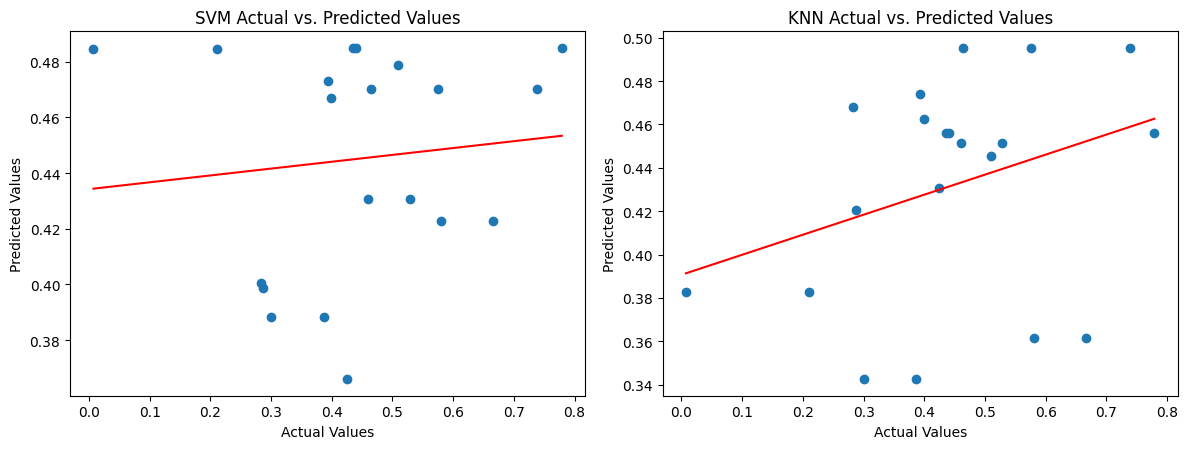

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#plot SVM
coefficients_svm = np.polyfit(y_test, predictions, 1)
slope_svm, intercept_svm = coefficients_svm
x_range_svm = np.linspace(min(y_test), max(y_test), 100)
regression_line_svm = slope_svm * x_range_svm + intercept_svm
axes[0].plot(x_range_svm, regression_line_svm, color='red', label='Regression Line')
axes[0].scatter(y_test, predictions)
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title("SVM Actual vs. Predicted Values")

#plot KNN
coefficients_knn = np.polyfit(knn_y_test, knn_y_pred, 1)
slope_knn, intercept_knn = coefficients_knn
x_range_knn = np.linspace(min(knn_y_test), max(knn_y_test), 100)
regression_line_knn = slope_knn * x_range_knn + intercept_knn
axes[1].plot(x_range_knn, regression_line_knn, color='red', label='Regression Line')
axes[1].scatter(knn_y_test, knn_y_pred)
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")
axes[1].set_title("KNN Actual vs. Predicted Values")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Random Forest

In [ ]:
rf_df = file_df[['popularity', 'explicit', 'tiktok_video_count', 'location_mention', 'count', 'weighted_average', 'class']]
rf_df.sample(5)

,popularity,explicit,tiktok_video_count,location_mention,count,weighted_average,class
162,0.484211,0,0.000167,0,0.000000,0.338997,0
112,0.526316,0,0.009743,1,0.028571,0.371344,0
1,0.852632,1,0.150508,1,0.085714,0.641995,1
51,0.168421,0,0.036477,1,0.028571,0.128838,0
70,0.557895,0,0.112753,1,0.971429,0.424352,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

# Selecting the features and the target variable
X = rf_df[['count', 'explicit', 'location_mention']]
y = rf_df[['class']]

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Creating and training Random Forest model
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=500)
random_forest_model.fit(X_train, y_train)

# Predictions using Random Forest
rf_predictions = random_forest_model.predict(X_test)
rf_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Evaluation - Classification Reports of Random Forest
rf_classification_report2 = classification_report(y_test, rf_predictions)

rf_probs = random_forest_model.predict_proba(X_test)[:, 1]
# Calculating AUC scores
rf_auc = roc_auc_score(y_test, rf_probs)

print("\nRandom Forest:")
print(rf_classification_report2)
print(f"AUC Score: {rf_auc:.2f}")


Random Forest:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.00      0.00      0.00         4

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

AUC Score: 0.66


## Confusion Matrix

Confusion Matrix:
[[16  0]
 [ 4  0]]


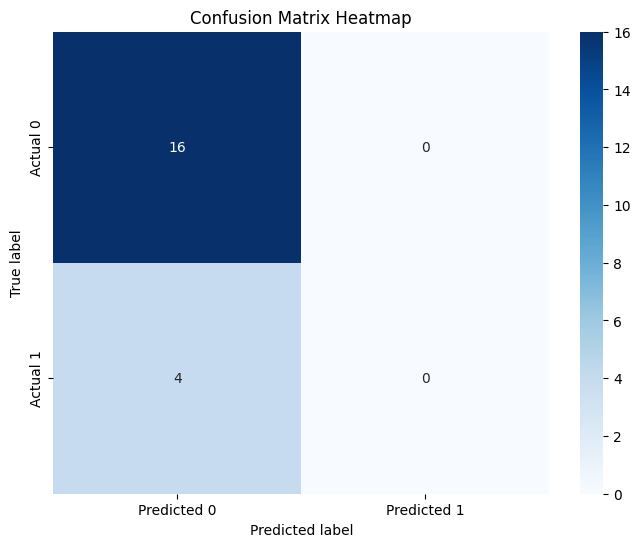

In [ ]:
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## XGBOOT

In [ ]:
#XGBoost

# Instantiate XGBClassifier for model construction
model = xgb.XGBClassifier(objective='binary:logistic')

# Define parameters for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best Model from Grid Search
best_model = grid_search.best_estimator_

# Formulate predictions on your test set (Model Evaluation)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Printing classification report for precision, recall, f1-score, and support
print("\nXGBoost Model (after tuning):")
report2point1 = classification_report(y_test, y_pred)
print('Classification Report:')
print(report2point1)
print(f"AUC Score: {rf_auc:.2f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits

XGBoost Model (after tuning):
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.00      0.00      0.00         4

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

AUC Score: 0.66


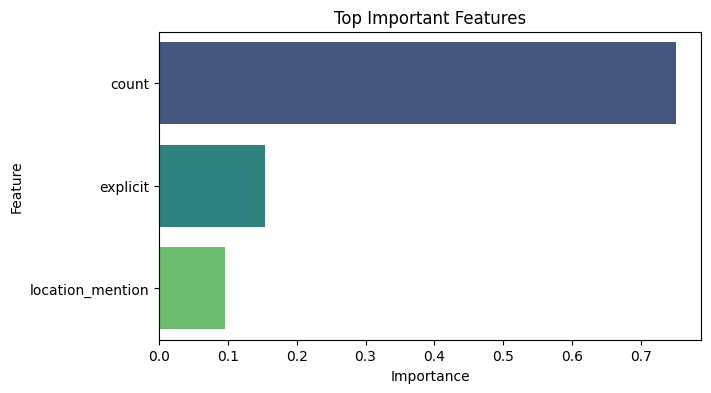

In [ ]:
# Extracting feature importance from the Random Forest model
feature_importances = random_forest_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top features
plt.figure(figsize=(7, 4))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top Important Features')
plt.show()

data=feature_importance_df

#Location Mentions

In [ ]:
from itertools import chain

file_df['location_list'] = file_df['names_of_location'].apply(lambda x: x.split(', ') if pd.notna(x) else [])
location_list = list(chain.from_iterable(file_df['location_list']))

location_list = [name.replace('L A', 'LA').lower() for name in location_list]
location_list = [name.replace('maimi', 'miami').replace('casalanca', 'casablanca').replace('camerron', 'cameroon') for name in location_list]

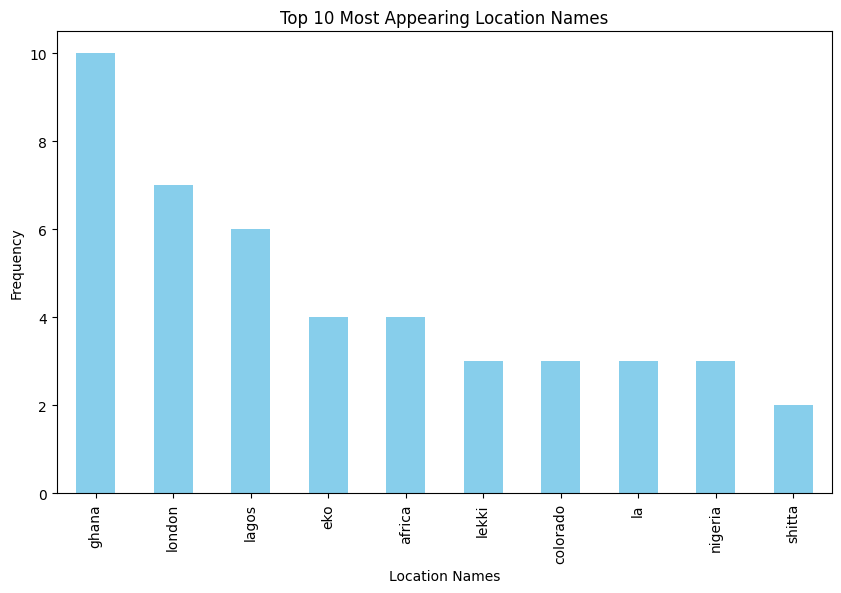

In [ ]:
# Step 1: Extract unique names and their frequencies
location_counts = pd.Series(location_list).value_counts()

# Step 2: Plot bar plot
plt.figure(figsize=(10, 6))
location_counts.head(10).plot(kind='bar', color='skyblue')
plt.xlabel('Location Names')
plt.ylabel('Frequency')
plt.title('Top 10 Most Appearing Location Names')
plt.show()

In [ ]:
# Create a table
location_counts_df = pd.DataFrame({'location_name': location_counts.index, 'count': location_counts.values})
location_counts_df.sample(5)

,location_name,count
16,accra,2
3,eko,4
26,ibiza,2
51,okadigbo,1
73,cali',1


In [ ]:
import geopandas as gpd
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)

locations = [geolocator.geocode(name) for name in location_list]
latitude = [loc.latitude if loc else None for loc in locations]
longitude = [loc.longitude if loc else None for loc in locations]

df = pd.DataFrame({'name': location_list, 'latitude': latitude, 'longitude': longitude})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

In [ ]:
location_gdf = pd.merge(gdf, location_counts_df, left_on='name', right_on='location_name', how='inner')
location_gdf

,name,latitude,longitude,geometry,location_name,count
0,london,51.489334,-0.144055,POINT (-0.14406 51.48933),london,7
1,london,51.489334,-0.144055,POINT (-0.14406 51.48933),london,7
2,london,51.489334,-0.144055,POINT (-0.14406 51.48933),london,7
3,london,51.489334,-0.144055,POINT (-0.14406 51.48933),london,7
4,london,51.489334,-0.144055,POINT (-0.14406 51.48933),london,7
...,...,...,...,...,...,...
147,asgard,60.748852,10.754121,POINT (10.75412 60.74885),asgard,1
148,abuja,9.064331,7.489297,POINT (7.48930 9.06433),abuja,2
149,abuja,9.064331,7.489297,POINT (7.48930 9.06433),abuja,2
150,addis ababa,9.035829,38.752413,POINT (38.75241 9.03583),addis ababa,1


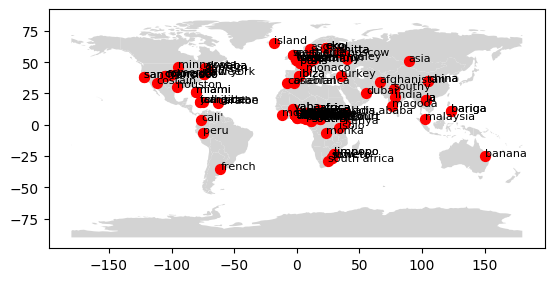

<Figure size 1600x1000 with 0 Axes>

In [ ]:
# Plot the choropleth map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgray')

# Plot the points on the map
gdf.plot(marker='o', color='red', markersize=50, ax=ax, label='Locations')

plt.figure(figsize=(16, 10))
# Add labels for each point
for x, y, label in zip(gdf['longitude'], gdf['latitude'], gdf['name']):
    if pd.notna(x) and pd.notna(y):
        ax.text(x, y, label, fontsize=8)

# Display the map
plt.show()

In [ ]:
admin_boundaries = gpd.read_file('/content/ngn_state.shp')

gdf_with_admin = gpd.sjoin(admin_boundaries, location_gdf, how='inner', op='intersects')
gdf_with_admin.sample(5)

,admin1Name,admin1Pcod,admin1RefN,admin1AltN,admin1Al_1,admin0Name,admin0Pcod,date,validOn,validTo,Shape_Leng,Shape_Area,geometry,index_right,name,latitude,longitude,location_name,count
24,Lagos,NG025,Lagos,None,None,Nigeria,NG,2016-11-29,2016-12-15,None,4.287770,0.300166,"POLYGON ((3.32387 6.67388, 3.32879 6.67337, 3....",87,lagos,6.455057,3.394179,lagos,6
18,Kaduna,NG019,Kaduna,None,None,Nigeria,NG,2016-11-29,2016-12-15,None,12.613678,3.645639,"POLYGON ((8.16953 11.48727, 8.16955 11.47969, ...",82,nigeria,9.600036,7.999972,nigeria,3
24,Lagos,NG025,Lagos,None,None,Nigeria,NG,2016-11-29,2016-12-15,None,4.287770,0.300166,"POLYGON ((3.32387 6.67388, 3.32879 6.67337, 3....",59,lekki,6.412332,4.094740,lekki,3
24,Lagos,NG025,Lagos,None,None,Nigeria,NG,2016-11-29,2016-12-15,None,4.287770,0.300166,"POLYGON ((3.32387 6.67388, 3.32879 6.67337, 3....",56,orimolade,6.641688,3.330945,orimolade,1
24,Lagos,NG025,Lagos,None,None,Nigeria,NG,2016-11-29,2016-12-15,None,4.287770,0.300166,"POLYGON ((3.32387 6.67388, 3.32879 6.67337, 3....",58,lekki,6.412332,4.094740,lekki,3


Text(0.5, 1.0, 'Geographical Distribution of Location Counts accross Nigeria')

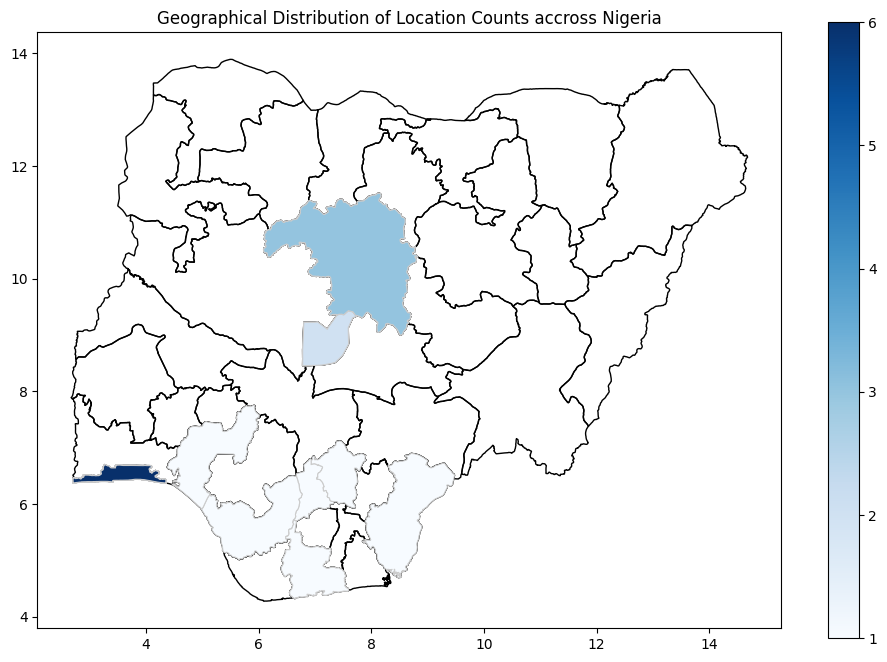

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
admin_boundaries.plot(color='none', edgecolor='black', linewidth=1, ax=ax)
gdf_with_admin.plot(column='count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Geographical Distribution of Location Counts accross Nigeria')

In [ ]:
location_gdf.to_csv('location_gdf.csv', index=False)

In [ ]:
lagos_admin_boundaries = gpd.read_file('/content/lagos_lga.geojson')

lg_gdf_with_admin = gpd.sjoin(lagos_admin_boundaries, location_gdf, how='inner', op='intersects')
lg_gdf_with_admin

,id,state_code,source,lga_code,lga_name,amap_code,global_id,geometry,index_right,name,latitude,longitude,location_name,count
0,u_boundary_lgas.64,LA,eHA_Polio,25011,Ikeja,NIE LAS KJA,172399ec-75a4-4878-8083-88b701c022f2,"MULTIPOLYGON (((3.36773 6.57174, 3.36763 6.571...",126,ikeja,6.596061,3.340787,ikeja,1
3,u_boundary_lgas.274,LA,eHA_Polio,25010,Ifako/Ijaye,NIE LAS FKJ,5af368e3-65e5-4f4b-a399-53d8d34b5a7b,"MULTIPOLYGON (((3.33668 6.62653, 3.33662 6.626...",56,orimolade,6.641688,3.330945,orimolade,1
10,u_boundary_lgas.441,LA,eHA_Polio,25013,Kosofe,NIE LAS KSF,8ab9d66a-8dc2-406a-b76e-92f9ee7848e9,"MULTIPOLYGON (((3.40635 6.55346, 3.40697 6.552...",130,gbagada,6.558073,3.383621,gbagada,2
10,u_boundary_lgas.441,LA,eHA_Polio,25013,Kosofe,NIE LAS KSF,8ab9d66a-8dc2-406a-b76e-92f9ee7848e9,"MULTIPOLYGON (((3.40635 6.55346, 3.40697 6.552...",129,gbagada,6.558073,3.383621,gbagada,2
11,u_boundary_lgas.477,LA,eHA_Polio,25018,Surulere,NIE LAS LSR,95c41101-4143-4abf-8adb-f63b79b09555,"MULTIPOLYGON (((3.36363 6.48910, 3.36421 6.487...",125,surulere,6.487201,3.353259,surulere,1
11,u_boundary_lgas.477,LA,eHA_Polio,25018,Surulere,NIE LAS LSR,95c41101-4143-4abf-8adb-f63b79b09555,"MULTIPOLYGON (((3.36363 6.48910, 3.36421 6.487...",124,ojuelegba,6.508653,3.368504,ojuelegba,1
13,u_boundary_lgas.543,LA,eHA_Polio,25020,Lagos Island,NIE LAS AAA,b328c781-eac6-4068-b614-02bc46f9bd15,"MULTIPOLYGON (((3.40770 6.44936, 3.40736 6.447...",88,lagos,6.455057,3.394179,lagos,6
13,u_boundary_lgas.543,LA,eHA_Polio,25020,Lagos Island,NIE LAS AAA,b328c781-eac6-4068-b614-02bc46f9bd15,"MULTIPOLYGON (((3.40770 6.44936, 3.40736 6.447...",89,lagos,6.455057,3.394179,lagos,6
13,u_boundary_lgas.543,LA,eHA_Polio,25020,Lagos Island,NIE LAS AAA,b328c781-eac6-4068-b614-02bc46f9bd15,"MULTIPOLYGON (((3.40770 6.44936, 3.40736 6.447...",91,lagos,6.455057,3.394179,lagos,6
13,u_boundary_lgas.543,LA,eHA_Polio,25020,Lagos Island,NIE LAS AAA,b328c781-eac6-4068-b614-02bc46f9bd15,"MULTIPOLYGON (((3.40770 6.44936, 3.40736 6.447...",92,lagos,6.455057,3.394179,lagos,6


Text(0.5, 1.0, 'Geographical Distribution of Location Counts accross Lagos')

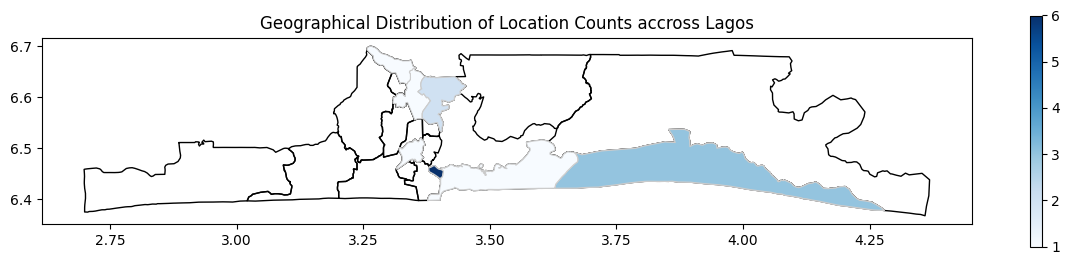

In [ ]:
'fig, ax = plt.subplots(figsize=(15, 3))
lagos_admin_boundaries.plot(color='none', edgecolor='black', linewidth=1, ax=ax)
lg_gdf_with_admin.plot(column='count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Geographical Distribution of Location Counts accross Lagos')